# Description SVM training

In this version, the training is done using only the description in the dataset

In [ ]:
import nltk
import time
import math
import tqdm
import json
import spacy
import joblib
import requests
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.svm import SVC
from bs4 import BeautifulSoup
from wikidata.client import Client
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, words
from collections import Counter, defaultdict
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/epicmusk/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/epicmusk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/epicmusk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /home/epicmusk/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## Collecting data

In [ ]:
# Sistemare i path per la consegna
dir_path   =  "/mnt/c/Users/fede6/Desktop/AI_R/Formazione/MNLP/HW1/"
train_path =  dir_path + "train.csv"
dev_path   =  dir_path + "valid.csv"

train_df = pd.read_csv(train_path, encoding='utf-8')
dev_df = pd.read_csv(dev_path, encoding='utf-8')

In [ ]:
def save_txt(filename, path, txt):
    with open(path + filename, 'w', encoding='utf-8') as output:
        json.dump(txt, output, ensure_ascii=False, indent=2)

def load_txt(filename, path):
    with open(path + filename, 'r', encoding='utf-8') as input_file:
        return json.load(input_file)

train_txt = load_txt(filename="train_paragraphs.txt", path=dir_path)
valid_txt = load_txt(filename="dev_paragraphs.txt", path=dir_path)

In [ ]:
train_df['paragraph'] = train_txt
dev_df['paragraph'] = valid_txt

In [ ]:
train_df.head()

,item,name,description,type,category,subcategory,label,paragraph
0,http://www.wikidata.org/entity/Q32786,916,2012 film by M. Mohanan,entity,films,film,cultural exclusive,916 is a 2012 Indian Malayalam -language drama...
1,http://www.wikidata.org/entity/Q371,!!!,American dance-punk band from California,entity,music,musical group,cultural representative,!!! ( / tʃ ( ɪ ) k . tʃ ( ɪ ) k . tʃ ( ɪ ) k /...
2,http://www.wikidata.org/entity/Q3729947,¡Soborno!,Mort & Phil comic,entity,comics and anime,comics,cultural representative,¡Soborno! (English: Bribery! ) is a 1977 comic...
3,http://www.wikidata.org/entity/Q158611,+44,American band,entity,music,musical group,cultural representative,+44 (read as Plus Forty-four ) was an American...
4,http://www.wikidata.org/entity/Q280375,1 Monk Street,"building in Monmouth, Wales",entity,architecture,building,cultural exclusive,"1 Monk Street, Monmouth was built as a Working..."


In [ ]:
dev_df.head()

,item,name,description,type,category,subcategory,label,paragraph
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,cultural representative,1. Fußball-Club Nürnberg Verein für Leibesübun...
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,cultural exclusive,77 Records was a British record company and la...
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,cultural representative,A Bug's Life (stylized in all lowercase) is a ...
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,cultural exclusive,A Gang Story ( French : Les Lyonnais ) is a 20...
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,cultural representative,"Aaron Copland ( / ˈ k oʊ p l ə n d / , KOHP -l..."


## TF-IDF computation

Definition of the vocabulary

In [ ]:
UNK_TOKEN = '<UNK>'
STOPWORDS = set(stopwords.words('english'))
ENGLISH_WORDS = set(words.words())
REMOVED_WORDS = ['ˈ', 'also', 'since', 'many']
lemmatizer = WordNetLemmatizer()

features = {
    'agnostic': [('often', 2.2322), ('international', 2.1234), ('may', 2.0655), ('esperanto', 2.0333), ('method', 1.9570), ('generally', 1.9501), ('process', 1.9305), ('include', 1.8571), ('pennine', 1.7650),
                 ('human', 1.7339), ('concept', 1.6969), ('others', 1.6616), ('person', 1.6555), ('christianity', 1.6547), ('user', 1.6487), ('individual', 1.5972), ('technique', 1.5803), ('different', 1.5376),
                 ('using', 1.5356), ('ford', 1.5322), ('highway', 1.5292), ('concern', 1.5266), ('design', 1.5145), ('form', 1.5034), ('usually', 1.4883), ('ultra', 1.4815), ('english', 1.4811), ('world', 1.4807),
                 ('use', 1.4707), ('olympic', 1.4581), ('ocean', 1.4501), ('country', 1.4429), ('mont', 1.4332), ('example', 1.4271), ('sale', 1.4151), ('urban', 1.4134), ('script', 1.4058), ('without', 1.3801),
                 ('humorous', 1.3713), ('point', 1.3579), ('pen', 1.3563), ('larger', 1.3508), ('sugarcane', 1.3494), ('catholic', 1.3400), ('mailing', 1.3261), ('single', 1.3260), ('asia', 1.3249), ('another', 1.3203),
                 ('male', 1.3031), ('plc', 1.2962), ('oficio', 2.2052), ('internationaal', 2.1822), ('proceeding', 2.1224), ('esperantisto', 2.1181), ('maxwell', 2.0813), ('methane', 2.0379), ('ulster', 2.0336),
                 ('oth', 2.0330), ('generalized', 2.0077), ('inclined', 1.8819), ('christianiki', 1.8594), ('highrise', 1.8104), ('penn', 1.7743), ('perske', 1.7418), ('use', 1.7270), ('humacao', 1.7202),
                 ('olympia', 1.7179), ('conceptually', 1.6797), ('technician', 1.6450), ('aso', 1.6336)],
    'representative': [('esperanto', 2.2424), ('building', 1.8979), ('olympic', 1.8969), ('applied', 1.8528), ('include', 1.8087), ('plant', 1.7681), ('pen', 1.6739), ('project', 1.6685), ('paper', 1.6543),
                       ('ford', 1.6358), ('legal', 1.6267), ('must', 1.6244), ('happy', 1.6131), ('international', 1.6102), ('sony', 1.6083), ('concept', 1.5771), ('person', 1.4951), ('another', 1.4861),
                       ('engine', 1.4588), ('content', 1.4223), ('musical', 1.4086), ('sugarcane', 1.4008), ('example', 1.3883), ('lentil', 1.3726), ('often', 1.3676), ('agency', 1.3466), ('plc', 1.3395),
                       ('provide', 1.3368), ('driver', 1.3355), ('online', 1.3321), ('interpretation', 1.3294), ('form', 1.3225), ('concern', 1.3211), ('reeder', 1.3181), ('narrative', 1.3052), ('opera', 1.3033),
                       ('variant', 1.2941), ('given', 1.2894), ('using', 1.2788), ('discipline', 1.2724), ('separate', 1.2688), ('information', 1.2626), ('currency', 1.2600), ('depending', 1.2590), ('asset', 1.2569),
                       ('significance', 1.2371), ('parapan', 1.2339), ('convention', 1.2165), ('kind', 1.2130), ('ability', 1.2107), ('esperantisto', 2.3280), ('builder', 2.0738), ('happiness', 2.0466),
                       ('olympia', 1.9897), ('inclined', 1.9563), ('application', 1.9493), ('planoisiennes', 1.8750), ('sonship', 1.8437), ('internationaal', 1.8307), ('forcing', 1.8179), ('mussel', 1.7722),
                       ('papaya', 1.7300), ('prohibition', 1.6972), ('redwood', 1.6762), ('anorodi', 1.6375), ('give', 1.6229), ('pellisier', 1.6008), ('legacy', 1.5837), ('concentration', 1.5531), ('engelskirchen', 1.5237)],
    'exclusive': [('origin', 2.1131), ('friedrich', 1.9394), ('leipzig', 1.9035), ('child', 1.8764), ('newspaper', 1.8721), ('medieval', 1.8251), ('period', 1.7568), ('traditional', 1.7372), ('socialist', 1.7357),
                  ('district', 1.7338), ('local', 1.6619), ('badminton', 1.6567), ('soup', 1.6482), ('russia', 1.6360), ('shanghai', 1.6082), ('owner', 1.5830), ('national', 1.5739), ('folk', 1.5577), ('died', 1.5495),
                  ('egyptian', 1.4714), ('god', 1.4627), ('current', 1.4595), ('nirmal', 1.4505), ('accompanied', 1.4488), ('radio', 1.4398), ('kind', 1.4295), ('pseudonym', 1.4273), ('wisdom', 1.4074), ('amft', 1.4063),
                  ('appeared', 1.4054), ('channel', 1.4052), ('schedule', 1.4033), ('literary', 1.4000), ('competed', 1.3923), ('reign', 1.3704), ('dynasty', 1.3691), ('drink', 1.3675), ('swedish', 1.3591),
                  ('quebec', 1.3524), ('league', 1.3415), ('der', 1.3348), ('honden', 1.3331), ('forest', 1.3304), ('circulation', 1.3263), ('otto', 1.3075), ('appointed', 1.3049), ('council', 1.3000), ('bar', 1.2983),
                  ('mufti', 1.2940), ('dead', 1.2881), ('badger', 2.3667), ('orientis', 2.2938), ('russes', 2.1058), ('sociales', 2.0644), ('friedman', 1.9573), ('newsgathering', 1.9507), ('leinster', 1.9087),
                  ('soundstage', 1.8122), ('medicinal', 1.8100), ('reife', 1.8030), ('currency', 1.8002), ('tradicionale', 1.7902), ('chil', 1.7821), ('owing', 1.7609), ('distributor', 1.7474), ('lobster', 1.7231),
                  ('appearance', 1.7123), ('compete', 1.6833), ('perimeter', 1.6825), ('schlüter', 1.6224)]
}

def get_penal_words(features):
    penalization_words = []
    suspicious_words = defaultdict(list)

    for label, word_weights in features.items():
        for word, weight in word_weights:
            if (
                word.lower() not in ENGLISH_WORDS and
                word.lower() not in STOPWORDS
            ):
                suspicious_words[label].append((word, weight))

    for label, words in suspicious_words.items():
        for word, score in words:
            penalization_words.append(word)
    return penalization_words

for word in REMOVED_WORDS:
    STOPWORDS.add(word)

penalization_words = get_penal_words(features)


Implementation of methods to compute the TF-IDF

In [ ]:
def penalizer(idf_, alpha=0.25, min_penalty=0.1):
    penalty =  1 - alpha*(1/(idf_ + 1))
    return max(penalty, min_penalty)

def tokenize(doc):
    tokens = word_tokenize(doc.lower())
    tokens = [w for w in tokens if w.isalpha() and w not in STOPWORDS]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return tokens

def tf(doc):
    tf_ = {}
    words = tokenize(doc)
    cnt = Counter(words)
    normalization_factor = len(words)
    for word, occs in cnt.items():
        tf_[word] = occs / normalization_factor

    return tf_

def idf(texts):
    idf_ = {}
    N = len(texts)
    tokenized_docs = [set(tokenize(doc)) for doc in texts]
    all_words = set(word for doc in tokenized_docs for word in doc)

    for word in tqdm.tqdm(all_words):
        doc_cnt = sum(1 for doc in tokenized_docs if word in doc)
        idf_[word] = math.log((1 + N) / (1 + doc_cnt)) + 1
    return idf_

def idf_by_category(df):
    categorical_idf = {}
    grouped = df.groupby('category')['paragraph'].apply(list)

    for cat, docs in grouped.items():
        categorical_idf[cat] = idf(docs)

    return categorical_idf

def tf_idf(tf_, idf_, word_index=None, unk_token=UNK_TOKEN):
    tfidf = {}
    unk_val = 0.0

    for word, tf_val in tf_.items():
        idf_val = idf_.get(word, 1.0)
        penalty = 0.3 if word in penalization_words else 1.0
        value = tf_val * idf_val * penalty

        if word_index is not None and word not in word_index:
            unk_val += value
        else:
            tfidf[word] = value

    if word_index is not None and unk_token in word_index:
        tfidf[unk_token] = unk_val

    return tfidf

def vectorize(tfidf_dict, word_index, unk_token=UNK_TOKEN):
    vec = np.zeros(len(word_index))
    unk_idx = word_index.get(unk_token)

    for word, value in tfidf_dict.items():
        if word in word_index:
            vec[word_index[word]] = value
        elif unk_idx is not None:
            vec[unk_idx] += value
    return vec

In [ ]:
idf_cat = idf_by_category(train_df)
train_tfidfs = []
dev_tfidfs = []

for _, row in tqdm.tqdm(train_df.iterrows(), total=len(train_df), colour='green'):
    doc = row['paragraph']
    cat = row['category']
    tf_ = tf(doc)
    idf_ = idf_cat.get(cat, {})
    tfidf = tf_idf(tf_, idf_)
    train_tfidfs.append(tfidf)

train_df['tf_idf'] = train_tfidfs

100%|████████████████████████████████████████████████████████████████████| 6251/6251 [00:05<00:00, 1057.05it/s]


In [ ]:
train_df.head()

,item,name,description,type,category,subcategory,label,paragraph,tf_idf
0,http://www.wikidata.org/entity/Q32786,916,2012 film by M. Mohanan,entity,films,film,cultural exclusive,916 is a 2012 Indian Malayalam -language drama...,"{'indian': 0.21848465862592362, 'malayalam': 0..."
1,http://www.wikidata.org/entity/Q371,!!!,American dance-punk band from California,entity,music,musical group,cultural representative,!!! ( / tʃ ( ɪ ) k . tʃ ( ɪ ) k . tʃ ( ɪ ) k /...,"{'tʃ': 0.4018646570636401, 'ɪ': 0.303772652926..."
2,http://www.wikidata.org/entity/Q3729947,¡Soborno!,Mort & Phil comic,entity,comics and anime,comics,cultural representative,¡Soborno! (English: Bribery! ) is a 1977 comic...,"{'english': 0.05184223924600517, 'bribery': 0...."
3,http://www.wikidata.org/entity/Q158611,+44,American band,entity,music,musical group,cultural representative,+44 (read as Plus Forty-four ) was an American...,"{'read': 0.0885609174389895, 'plus': 0.0947988..."
4,http://www.wikidata.org/entity/Q280375,1 Monk Street,"building in Monmouth, Wales",entity,architecture,building,cultural exclusive,"1 Monk Street, Monmouth was built as a Working...","{'monk': 0.13384657659845203, 'street': 0.0940..."


In [ ]:
dev_df.head()

,item,name,description,type,category,subcategory,label,paragraph
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,cultural representative,1. Fußball-Club Nürnberg Verein für Leibesübun...
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,cultural exclusive,77 Records was a British record company and la...
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,cultural representative,A Bug's Life (stylized in all lowercase) is a ...
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,cultural exclusive,A Gang Story ( French : Les Lyonnais ) is a 20...
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,cultural representative,"Aaron Copland ( / ˈ k oʊ p l ə n d / , KOHP -l..."


## Test SVM

#### Categorical TF-IDF

In [ ]:
vocab = sorted(set(word for doc in train_df['paragraph'] for word in tokenize(doc)))
word_index = {word: idx for idx, word in enumerate(vocab)}

idf_cat = idf_by_category(train_df)

tfidf_dicts = train_df['tf_idf'].to_list()
val_docs = dev_df['tf_idf'].to_list()

X = np.array([vectorize(doc_tfidf, word_index) for doc_tfidf in tfidf_dicts])
X_val = np.array([vectorize(doc_tfidf, word_index) for doc_tfidf in val_docs])

y = np.array(train_df['label'])
y_val = np.array(dev_df['label'])

100%|███████████████████████████████████████████████████████████████████| 4769/4769 [00:00<00:00, 87330.97it/s]


#### Non-categorical TF_IDF

In [ ]:
vocab = sorted(set(word for doc in train_df['paragraph'] for word in tokenize(doc)))
word_index = {word: idx for idx, word in enumerate(vocab)}

val_docs = [tf_idf(tf(doc), idfs) for doc in dev_df['description']]
val_idfs = idf(dev_df['description'])

X = np.array([vectorize(doc_tfidf, word_index) for doc_tfidf in tfidf_dicts])
X_val = np.array([vectorize(doc_tfidf, word_index) for doc_tfidf in val_docs])
y = np.array(train_df['label'])
y_val = np.array(dev_df['label'])

100%|████████████████████████████████████████████████████████████████████| 966/966 [00:00<00:00, 104234.46it/s]


#### One-Hot-Encoding + Categorical TF-IDF

In [ ]:
cols_to_encode = ['type', 'subcategory']

encoder = OneHotEncoder(handle_unknown='ignore')
onehotvec_train = encoder.fit_transform(train_df[cols_to_encode]).toarray().astype(float)
onehotvec_valid = encoder.transform(dev_df[cols_to_encode]).toarray().astype(float)

dictionary = train_df['tf_idf'].to_list()

vocab = sorted(set(word for doc in train_df['paragraph'] for word in tokenize(doc)))
word_index = {word: idx for idx, word in enumerate(vocab)}
word_index[UNK_TOKEN] = len(word_index)

for _, row in tqdm.tqdm(dev_df.iterrows(), total=len(dev_df), colour='green'):
    doc = row['paragraph']
    cat = row['category']
    tf_ = tf(doc)
    idf_ = idf_cat.get(cat, {})
    tfidf = tf_idf(tf_, idf_, word_index=word_index, unk_token=UNK_TOKEN)
    dev_tfidfs.append(tfidf)
dev_df['tf_idf'] = dev_tfidfs

val_docs = dev_df['tf_idf'].to_list()

X = np.array([vectorize(doc_tfidf, word_index, unk_token=UNK_TOKEN) for doc_tfidf in dictionary])
X_val = np.array([vectorize(doc_tfidf, word_index, unk_token=UNK_TOKEN) for doc_tfidf in val_docs])
y = np.array(train_df['label'])
y_val = np.array(dev_df['label'])

X = np.hstack([X, onehotvec_train])
X_val = np.hstack([X_val, onehotvec_valid])

100%|███████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 835.37it/s]


## Weights computation

In [ ]:
freq_dict = {
    "cultural agnostic": 0.2995,
    "cultural representative": 0.2700,
    "cultural exclusive": 0.4305
}

def weights_computation(freq_dict):
    weights = {k: 1/v for k, v in freq_dict.items()}
    norm_factor = sum(weights.values())
    norm_weights = {k: v/norm_factor for k, v in weights.items()}
    return norm_weights

## Paragraph training

In [ ]:
GRIDSEARCH = False

In [ ]:
from itertools import product

C_values = [5, 6, 7, 8, 9, 10]
gamma = 'scale'
kernels = ['linear']

best_score = 0
best_params = {}
best_model = None

class_weights = weights_computation(freq_dict)

for kernel, C in product(kernels, C_values):
    print(f"Testing: C={C}, gamma={gamma}, kernel={kernel}")

    svc = SVC(C=C, gamma=gamma, kernel=kernel, class_weight=class_weights)

    try:
        svc.fit(X, y)

        y_pred = svc.predict(X_val)
        score = accuracy_score(y_val, y_pred)

        print(f"Accuracy: {score:.4f}")
        print(f"F1 macro score: {f1_score(y_val, y_pred, average='macro'):.4f}")

        if score > best_score:
            best_score = score
            best_params = {'C': C, 'gamma': gamma, 'kernel': kernel}
            best_model = svc

    except Exception as e:
        print(f"ERROR! Params:\tC={C}, gamma={gamma}, kernel={kernel}: {e}")

GRIDSEARCH = True

Testing: C=5, gamma=scale, kernel=linear
Accuracy: 0.7167
F1 macro score: 0.7018
Testing: C=6, gamma=scale, kernel=linear
Accuracy: 0.7233
F1 macro score: 0.7098
Testing: C=7, gamma=scale, kernel=linear
Accuracy: 0.7333
F1 macro score: 0.7197
Testing: C=8, gamma=scale, kernel=linear
Accuracy: 0.7167
F1 macro score: 0.7043
Testing: C=9, gamma=scale, kernel=linear
Accuracy: 0.7067
F1 macro score: 0.6957
Testing: C=10, gamma=scale, kernel=linear
Accuracy: 0.7033
F1 macro score: 0.6932


In [ ]:
if GRIDSEARCH:
    print("Best parameters found:", best_model)
    y_pred = best_model.predict(X_val)
    print(classification_report(y_val, y_pred))
else:
    svc = joblib.load(dir_path + "PenaltySVM.pkl")
    print("Best parameters found:", svc)
    y_pred = svc.predict(X_val)
    print(classification_report(y_val, y_pred))

Best parameters found: SVC(C=7,
    class_weight={'cultural agnostic': 0.3565110774234955,
                  'cultural exclusive': 0.24802570891599746,
                  'cultural representative': 0.395463213660507},
    kernel='linear')
                         precision    recall  f1-score   support

      cultural agnostic       0.82      0.87      0.84       117
     cultural exclusive       0.61      0.68      0.65        76
cultural representative       0.73      0.62      0.67       107

               accuracy                           0.73       300
              macro avg       0.72      0.72      0.72       300
           weighted avg       0.73      0.73      0.73       300



In [ ]:
joblib.dump(best_model, dir_path + "PenaltySVM_OOV.pkl")

['/mnt/c/Users/fede6/Desktop/AI_R/Formazione/MNLP/HW1/PenaltySVM_OOV.pkl']

In [ ]:
classes = ['agnostic', 'representative', 'exclusive']
tfidf_size = len(word_index)
reverse_word_index = {v: k for k, v in word_index.items()}
threshold = 1.1

most_influent_words = {
    'agnostic': [],
    'representative': [],
    'exclusive': []
}

for i, class_name in enumerate(classes):
    top_features = np.argsort(best_model.coef_[i])[::-1]

    for feat_idx in top_features:
        if feat_idx < tfidf_size:
            word = reverse_word_index[feat_idx]
            weight = best_model.coef_[i][feat_idx]
            if weight < threshold:
                break
            else:
                most_influent_words[class_name].append((word, round(weight, 4)))

## Mispredictions analysis

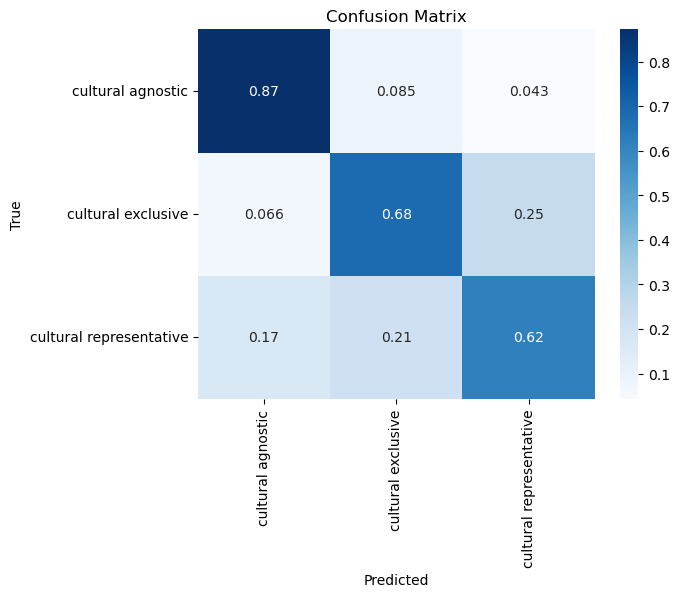

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_val, y_pred, normalize='true')
labels = np.unique(y_val)
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
error_df = dev_df.copy()
error_df['true_label'] = y_val
error_df['predicted'] = y_pred
error_df['correct'] = error_df['true_label'] == error_df['predicted']

mistakes = error_df[~error_df['correct']]

mistakes[['name', 'tf_idf', 'true_label', 'predicted']].sample(20, random_state=42)

,name,tf_idf,true_label,predicted
115,Geneva Open Challenger,"{'geneva': 0.045454545454545456, 'open': 0.097...",cultural representative,cultural exclusive
0,1. FC Nürnberg,"{'verein': 0.01639344262295082, 'für': 0.01639...",cultural representative,cultural exclusive
86,Dione Lucas,"{'lucas': 0.06451612903225806, 'pronounced': 0...",cultural exclusive,cultural representative
116,geoponici,"{'latinized': 0.043478260869565216, 'form': 0....",cultural representative,cultural exclusive
78,Cultural Revolution,"{'cultural': 0.2282983273735388, 'revolution':...",cultural representative,cultural exclusive
109,Francis Coventry,"{'francis': 0.18800020263869077, 'k': 0.150037...",cultural exclusive,cultural representative
38,Bauhaus Archive,"{'bauhaus': 0.06451612903225806, 'archive': 0....",cultural representative,cultural exclusive
262,Studio 4°C,"{'studio': 0.2942062602061816, 'stylized': 0.2...",cultural exclusive,cultural representative
17,Anasyrma,"{'ancient': 0.08568732836275197, 'greek': 0.10...",cultural representative,cultural agnostic
46,Boomerang,"{'american': 0.0875463996938888, 'cable': 0.18...",cultural exclusive,cultural representative


In [ ]:
mistakes_per_label = mistakes.groupby('true_label')['predicted'].value_counts().unstack(fill_value=0)
mistakes_per_label

predicted,cultural agnostic,cultural exclusive,cultural representative
true_label,,,
cultural agnostic,0,10,5
cultural exclusive,5,0,19
cultural representative,18,23,0


In [ ]:
tokens_errors = [token for doc in mistakes['paragraph'] for token in tokenize(doc)]
common_error_words = Counter(tokens_errors).most_common(50)
print("Most common words in misclassified samples:")
print(common_error_words)

Most common words in misclassified samples:
[('music', 20), ('dance', 18), ('party', 18), ('known', 15), ('style', 15), ('film', 15), ('world', 14), ('city', 14), ('term', 13), ('century', 13), ('political', 13), ('award', 13), ('time', 12), ('used', 12), ('festival', 12), ('european', 12), ('folk', 12), ('first', 11), ('work', 11), ('state', 11), ('german', 10), ('arabic', 10), ('ancient', 10), ('japan', 10), ('fiction', 10), ('including', 9), ('population', 9), ('role', 9), ('traditional', 9), ('french', 9), ('group', 9), ('building', 9), ('london', 9), ('founded', 8), ('island', 8), ('area', 8), ('people', 8), ('animation', 8), ('song', 8), ('network', 8), ('catholic', 8), ('church', 8), ('religion', 8), ('science', 8), ('pit', 8), ('often', 7), ('africa', 7), ('name', 7), ('italian', 7), ('company', 7)]


In [ ]:
classes_mistakes = defaultdict(list)

for _, row in mistakes.iterrows():
    tokens = tokenize(row['paragraph'])
    classes_mistakes[row['label']].extend(tokens)

class_tokens = defaultdict(list)

for _, row in dev_df.iterrows():
    tokens = tokenize(row['paragraph'])
    class_tokens[row['label']].extend(tokens)

class_er = {}

for class_label in classes_mistakes:
    error_counts = Counter(classes_mistakes[class_label])
    total_counts = Counter(class_tokens[class_label])

    token_rates = {}
    for token, err_count in error_counts.items():
        total = total_counts.get(token, 1)
        token_rates[token] = [err_count / total, err_count, total]

    class_er[class_label] = dict(sorted(token_rates.items(), key=lambda x: x[1][0], reverse=True))


In [ ]:
def see_mistakes(cl, word, mistakes_vocab=class_er):
    print(f"Mistakes with '{word}' on: '{cl}'")
    print(mistakes_vocab[cl][word])

classes = ['cultural agnostic', 'cultural representative', 'cultural exclusive']
for cl in classes:
    try:
        word = 'known'
        see_mistakes(cl, word=word)
    except Exception as e:
        if isinstance(e, KeyError):
            print(f"The word {e} is not in the mistakes vocabulary")
        else:
            print(f"ERROR! Error in the mistake dictionary {e}")


Mistakes with 'known' on: 'cultural agnostic'
The word 'known' is not in the mistakes vocabulary
Mistakes with 'known' on: 'cultural representative'
[0.2692307692307692, 7, 26]
Mistakes with 'known' on: 'cultural exclusive'
[0.42105263157894735, 8, 19]


In [ ]:
mistakes.groupby('category').size().sort_values(ascending=False).head(10)

category
history                    8
politics                   6
philosophy and religion    6
music                      6
books                      5
architecture               5
media                      5
fashion                    5
literature                 5
films                      5
dtype: int64

In [ ]:
mistakes.groupby('subcategory').size().sort_values(ascending=False).head(10)

subcategory
museum                 3
religion               3
acting style           2
book                   2
government             2
geographic location    2
dance                  2
film genre             2
music genre            2
animation studio       2
dtype: int64

#### Examples of most influent words not in the english vocabulary

Class: agnostic
  llc (1.2878)
  breithorn (1.2847)
  earliest (1.2038)
  creating (1.2016)
  camacho (1.1910)
  zafra (1.1910)
  rosa (1.1908)
  panj (1.1612)
  english (1.1569)
  filmmaker (1.1529)
  pepsico (1.1383)
  nicene (1.1170)

Class: representative
  zafra (1.1910)
  camacho (1.1910)
  bibo (1.1380)
  adventism (1.1202)

Class: exclusive
  egypt (1.6379)
  norwegian (1.3237)
  played (1.2834)
...
  olympics (1.1648)
  khmer (1.1554)
  dengeki (1.1380)
  colombian (1.1068)